# Memory task machine learning
## Matt Oberhardt

### Initial setup

In [172]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%autoreload 2
%matplotlib inline  


## set options ##

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so i can see all rows of dfs
pd.set_option('display.max_columns', 500)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

## import my memorytools module ##

import memorytools as mt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# Load up the memory & demographic data:

# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)

# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

# add memory composite features:
data = mt.add_composite_features_to_data(data)

Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)
memory features loaded from file: memory_data_with_features.p (input data was ignored)
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Machine learning setup

In [107]:
from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# load feature categories
fcats = mt.define_feature_categories()


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Run random forest after age-matching and sample balancing, with different feature sets

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

[]
dropped 299 rows to remove all nas from data
na rows have been dropped (if there were any)


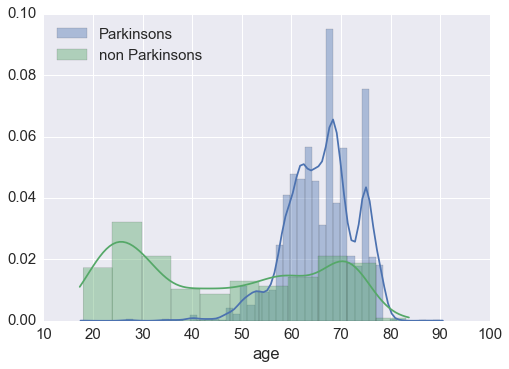

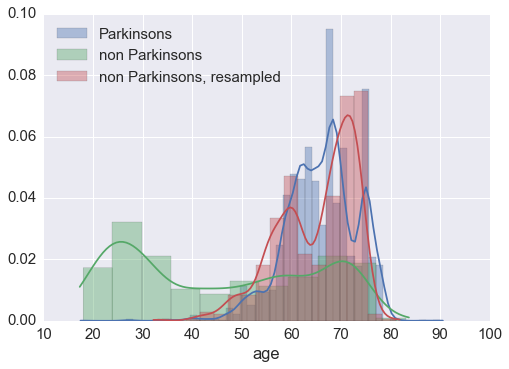

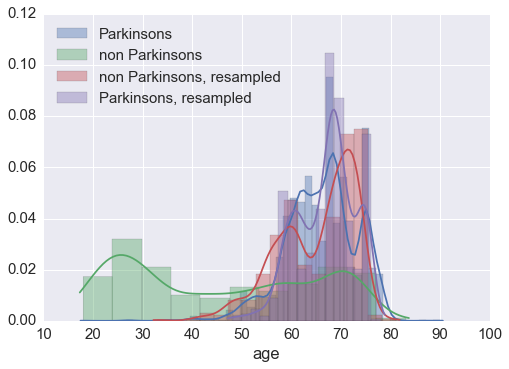

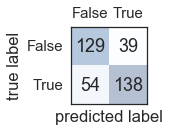

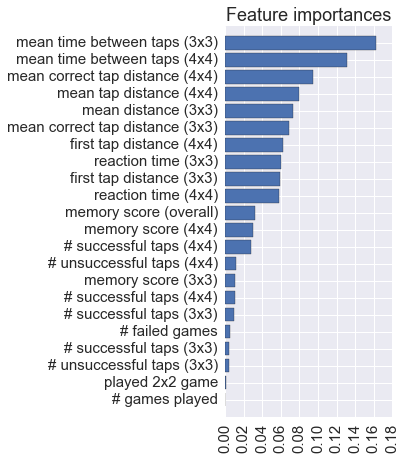

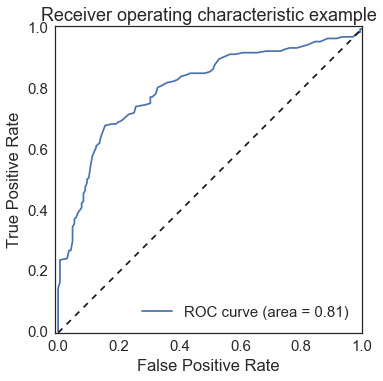



ranksum pval for dist. resampling = 0.125079398268
ranksum pval for sample balanced = 0.00291707974219


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.779661016949
recall: 0.71875
F1: 0.747967479675
training accuracy: 1.0
test accuracy: 0.741666666667
random accuracy would be 0.5
##########################




In [221]:
# Run with only in-game features 
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + ['age']
MLexcludecols = ['age']
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[1,1,1,1,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs



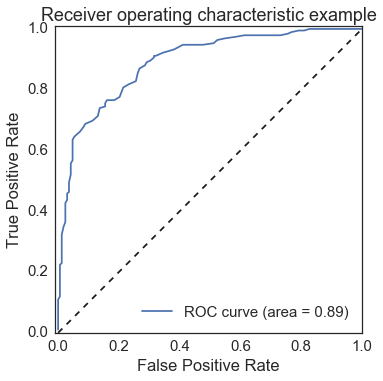

In [216]:
mt.plot_roc_curve(y_true, y_pred_proba)
#y_pred_proba
pass


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

[]
dropped 299 rows to remove all nas from data
na rows have been dropped (if there were any)


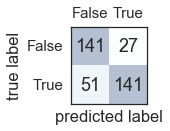

IndexError: list index out of range

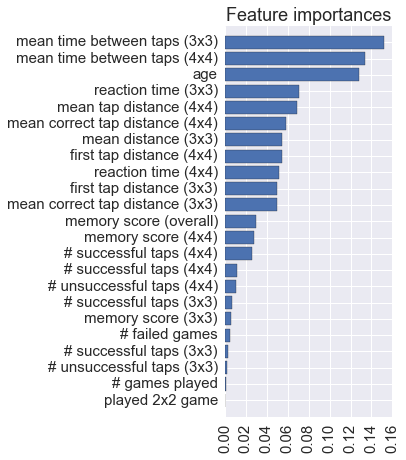

In [208]:
# Run with in-game features and age
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + ['age']
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,0,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred = outs


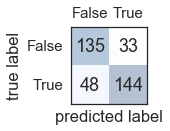

In [167]:
mt.render_confusion_matrix(y_test, y_pred)#, pos_class=True, neg_class=False):


#    sns.set(style="darkgrid", color_codes=True, font_scale=1.5)



Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['gender', 'education']
dropped 303 rows to remove all nas from data
na rows have been dropped (if there were any)
RanksumsResult(statistic=-1.6758171961546449, pvalue=0.093774004772043687)
RanksumsResult(statistic=-4.5827575819839907, pvalue=4.588839153636774e-06)
training accuracy: 1.0
test accuracy: 0.819444444444
num actual positives = 600
num actual negatives = 600
random accuracy would be 0.5




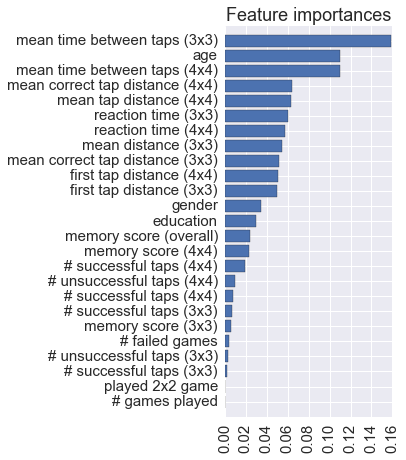

In [117]:
# Run with in-game features and demographic features
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic']
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,0,1,1], toPrint=True, MLexcludecols=MLexcludecols)    


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['gender', 'phoneInfo', 'education']
dropped 303 rows to remove all nas from data
na rows have been dropped (if there were any)


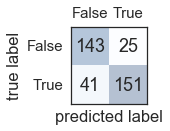

RanksumsResult(statistic=-1.9223332253762195, pvalue=0.054563841841394949)
RanksumsResult(statistic=0.23132030327849246, pvalue=0.81706597464342912)
training accuracy: 1.0
test accuracy: 0.816666666667
num actual positives = 600
num actual negatives = 600
random accuracy would be 0.5




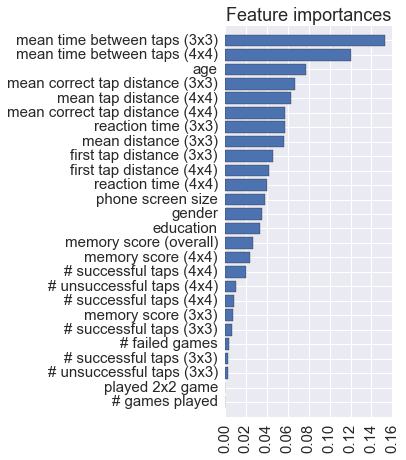

In [174]:
# Run with in-game features and demographic features and phone features
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
#fcats.rem
features.remove('smartphone')
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,0,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
# I think this one isn't fair...


### Try running model with other outputs than Parkinsons

In [108]:
# Run with in-game features and demographic features and phone features
# predict 
fcats = mt.define_feature_categories()
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
MLexcludecols = ['hasParkinsons']
labelcol = 'medTimepoint'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=True, toPrint=True, MLexcludecols=MLexcludecols)    
! fix code !! 

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['smartphone', 'gender', 'phoneInfo', 'education']
dropped 303 rows to remove all nas from data


KeyError: 'hasParkinsons'

In [107]:
fcats

{'demographic': ['age', 'gender', 'education'],
 'game': ['game_numFails',
  'game_score',
  'game_numGames',
  '9_numsuccesses',
  '9_numunsuccesses',
  '9_meandist',
  '9_successful',
  '9_gamescore',
  '9_latency',
  '9_firstdist',
  '9_meanDt',
  '9_meansuccessfuldist',
  '16_firstdist',
  '16_meandist',
  '16_numsuccesses',
  '16_gamescore',
  '16_latency',
  '16_numunsuccesses',
  '16_successful',
  '16_meanDt',
  '16_meansuccessfuldist',
  'played_game4'],
 'output': ['hasParkinsons',
  'medTimepoint',
  'brainStim',
  'surgery',
  'nyearsOnMeds',
  'nyearsOffMeds',
  'nyearsParkinsons'],
 'person': ['healthCode'],
 'phone': ['phoneInfo', 'smartphone'],
 'time': ['game_endDate', 'createdOn', 'game_startDate']}

In [8]:
# visualize this new dataset (resampled):

##featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
##features_df = data[["game_score",'16_gamescore','hasParkinsons']]
#fplot = features_df[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
#plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
##fplot = fplot.dropna()
#g = sns.pairplot(fplot, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)


Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Features converted to numbers:

['gender', 'education']
dropped 303 rows to remove all nas from data
na rows have been dropped (if there were any)


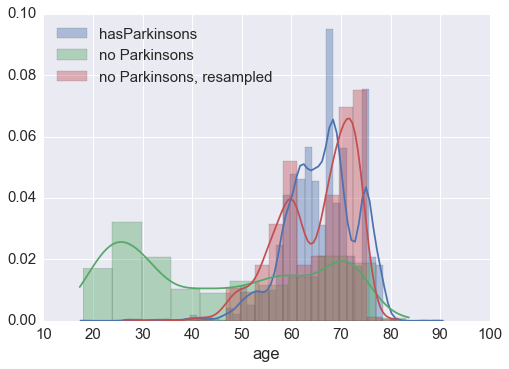

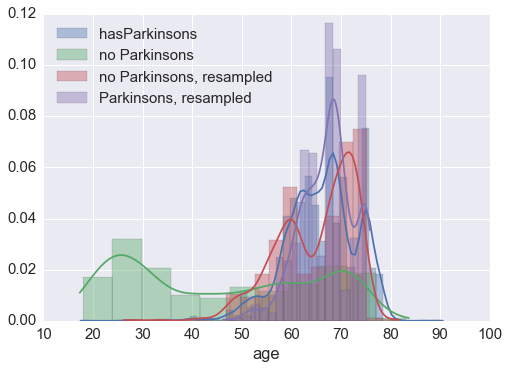

In [29]:
# Run ML with all features, and do many resamplings



fcats = mt.define_feature_categories()
features = fcats['game'] + fcats['demographic'] + ['hasParkinsons'] #+ fcats['output']
#features.remove('medTimepoint')
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, toPlot=True)


In [96]:
features = fcats['game'] + ['hasParkinsons'] + ['age']
#MLexcludecols = ['age']
MLexcludecols = []
labelcol = 'hasParkinsons'

numiters = 10

train_accs = []
test_accs = []
rand_accs = []

for n in range(numiters):
    print 'iteration %s' % n
    with mt.suppress_stdout():
        outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=False, toPrint=False, MLexcludecols=MLexcludecols)            

    mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc = outs
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    rand_accs.append(rand_acc)

        #return train_accs, test_accs, rand_accs

#with mt.suppress_stdout():
#    for n in range(numiters):

#for n in range(numiters):
#    print n
#    d = data.copy()

#    outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=False, toPrint=False, MLexcludecols=MLexcludecols)    


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [97]:
X_names.__class__

numpy.ndarray

NameError: name 'X_names' is not defined

In [102]:
X_names[indices]

array(['9_meanDt', u'age', '16_meanDt', '16_meandist',
       '16_meansuccessfuldist', '9_latency', '9_meandist', '16_latency',
       '16_firstdist', '9_firstdist', '9_meansuccessfuldist',
       u'game_score', '16_gamescore', '16_numsuccesses',
       '16_numunsuccesses', '16_successful', '9_gamescore',
       '9_numsuccesses', u'game_numFails', '9_numunsuccesses',
       '9_successful', 'played_game4', u'game_numGames'], dtype=object)

In [53]:
print test_accs
#print np.mean(test_accs)
ax = sns.boxplot(x="day", y="total_bill", data=tips)
>>> ax = sns.swarmplot(x="day", y="total_bill", data=tips, color=".25")






[0.81111111111111112, 0.83333333333333337, 0.7416666666666667, 0.77777777777777779, 0.80555555555555558, 0.81388888888888888, 0.80000000000000004, 0.82499999999999996, 0.78888888888888886, 0.80555555555555558]
0.800277777778


In [83]:
test_accs = pd.Series(test_accs)
train_accs = pd.Series(train_accs)
rand_accs = pd.Series(rand_accs)

X_names

array([u'game_numFails', u'game_score', u'game_numGames', '9_numsuccesses',
       '9_numunsuccesses', '9_meandist', '9_successful', '9_gamescore',
       '9_latency', '9_firstdist', '9_meanDt', '9_meansuccessfuldist',
       '16_firstdist', '16_meandist', '16_numsuccesses', '16_gamescore',
       '16_latency', '16_numunsuccesses', '16_successful', '16_meanDt',
       '16_meansuccessfuldist', 'played_game4', u'age'], dtype=object)

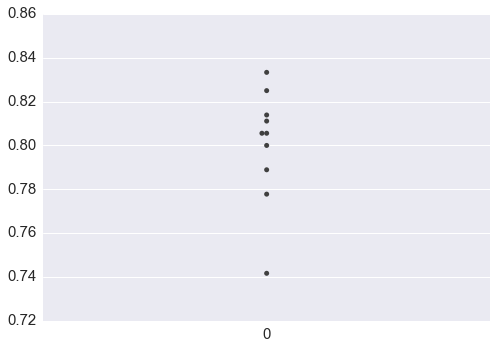

In [61]:

#ax = sns.boxplot(x=test_accs, orient='v')
ax = sns.swarmplot(data=test_accs, color=".25")


In [ ]:
# try predicting  

# Parkinsons patients: 322
# game records, Parkinsons 6164
# non-Parkinsons patients: 525
# game records, non-Parkinsons 1690


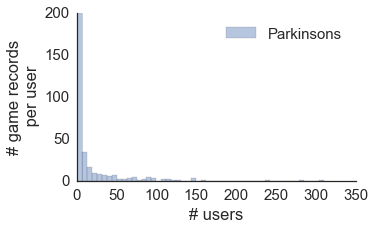

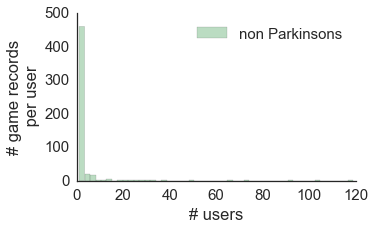

In [94]:
# visualize the data as a whole

#sns.
sns.set(style="white", font_scale=1.5)

Pgroups = data.groupby('hasParkinsons')
dp = Pgroups.get_group(True)
dnp = Pgroups.get_group(False)

# plot dists:
distP = dp['healthCode'].value_counts()
distNP = dnp['healthCode'].value_counts()

#array, bin_edges = np.histogram(data['healthCode'].value_counts(), bins=20)
#plt.figure()
#ax1 = sns.distplot(distP, kde=False, label='Parkinsons', bins=20)
#ax2 = sns.distplot(distNP, kde=False, label='non Parkinsons', bins=20)
#plt.xlabel('Users')
#plt.ylabel('# Game records per user')
#plt.legend(loc=4)

figsizes = (5,3)

plt.figure(figsize=figsizes)
ax1 = sns.distplot(distP, kde=False, label='Parkinsons', color='b')
plt.xlabel('# users')
plt.ylabel('# game records\n per user')
plt.legend(loc=1)
sns.despine()

plt.figure(figsize=figsizes)
ax2 = sns.distplot(distNP, kde=False, label='non Parkinsons', color='g')
plt.xlabel('# users')
plt.ylabel('# game records\n per user')
plt.legend(loc=1)
sns.despine()

print '# Parkinson''s patients:', len(distP)
print '# game records, Parkinson''s', distP.sum()

print '# non-Parkinson''s patients:', len(distNP)
print '# game records, non-Parkinson''s', distNP.sum()


In [10]:
# To Do:

# package the resampling code into a function

# add age back in as variable now, and rerun random forest
# try logistic regression, with l1 (lasso) (minimize # features)

# do pca of outputs, and see if we can be more predictive
# split data by person and check on drugs vs not on drugs (what is predictive)
# time series analysis of indiv. patients, looking at the yes and no data?
# symptom variance individual patients plot?
# run rand forest with all in-game features & sample balancing but not correction for age



In [32]:
data.shape

In [33]:
a = 2
a

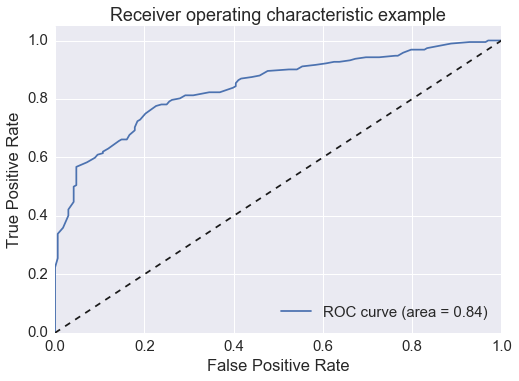